# Mathematical Underpinnings - Lab 7

In [66]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [67]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [68]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    # density of multivariate normal distribution is e.g. here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [69]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

# np.random.seed(123)
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))


In [70]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [71]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [72]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.297772030117542

### c)

In [73]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term)

### d)

In [74]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [76]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 1s 18ms/step - loss: -0.0310 - val_loss: -0.0435
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0531 - val_loss: -0.0601
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0652 - val_loss: -0.0694
Epoch 4/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0722 - val_loss: -0.0752
Epoch 5/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0765 - val_loss: -0.0794
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0802 - val_loss: -0.0828
Epoch 7/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0832 - val_loss: -0.0859
Epoch 8/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0863 - val_loss: -0.0887
Epoch 9/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0885 - val_loss: -0.0916
Epoch 10/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0913 - val_lo

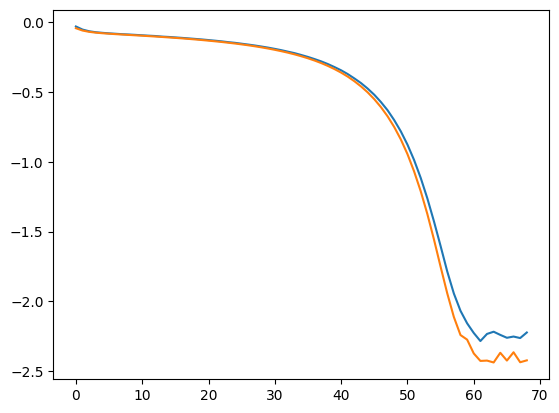

In [77]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [78]:
t_x_pred = model.predict(x)[:,0]

625/625 [==============================] - 1s 1ms/step


In [79]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

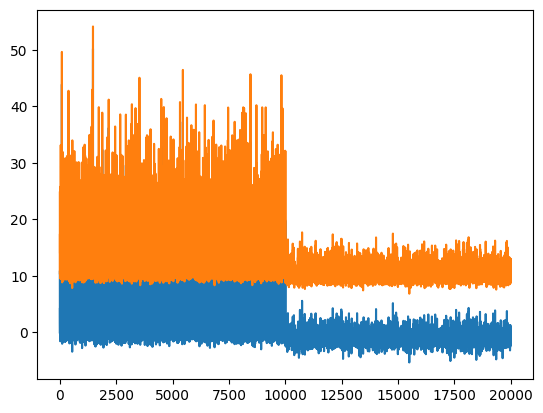

In [80]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

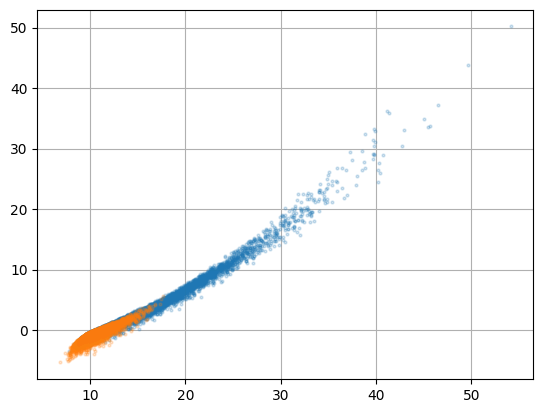

In [81]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

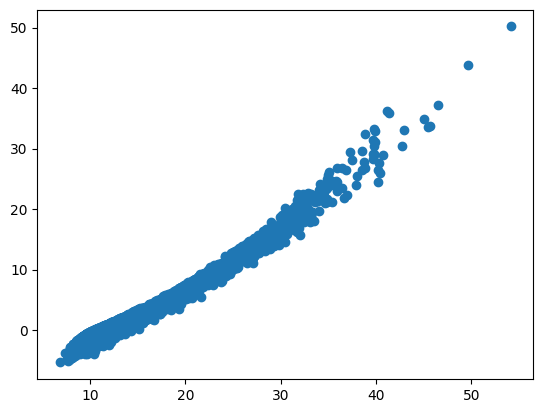

In [82]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [83]:
DV_fun(y, t_x_pred)

2.298405840721312

In [84]:
DV_fun(y, t_x_opt)

2.297772030117542

In [85]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [86]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

625/625 [==============================] - 1s 1ms/step


In [87]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [88]:
DV_fun(y_new, t_x_pred)

2.1322572419216588

In [89]:
DV_fun(y_new, t_x_opt)

2.31582903569026

### f)

In [92]:
# HOMEWORK - just f)

In [90]:
def NWJ_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.reduce_sum(tf.math.multiply(tf.math.exp(tf.subtract(T_x,tf.convert_to_tensor(1.0))),
                                                      tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2
    return -(first_term - second_term)

In [91]:
def NWJ_fun(y, t):
    n1 = np.sum(y) #number of samples from distribution p
    n2 = np.sum(1-y) #number of samples from distribution q
    t1 = np.sum(t*y)# sum of samples from distribution p
    t2 = np.sum(np.exp(t-1)*(1-y))# sum of samples from distribution q

    return t1/n1-t2/n2

In [93]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [94]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.0595 - val_loss: 0.0042
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0080 - val_loss: -0.0185
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0280 - val_loss: -0.0355
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0433 - val_loss: -0.0487
Epoch 5/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0549 - val_loss: -0.0589
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0641 - val_loss: -0.0669
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0711 - val_loss: -0.0732
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0769 - val_loss: -0.0782
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: -0.0815 - val_loss: -0.0825
Epoch 10/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0855 - val_loss

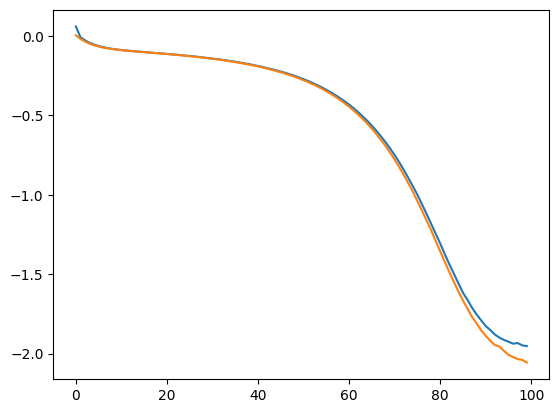

In [95]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [96]:
t_x_pred = model.predict(x)[:,0]
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

625/625 [==============================] - 1s 1ms/step


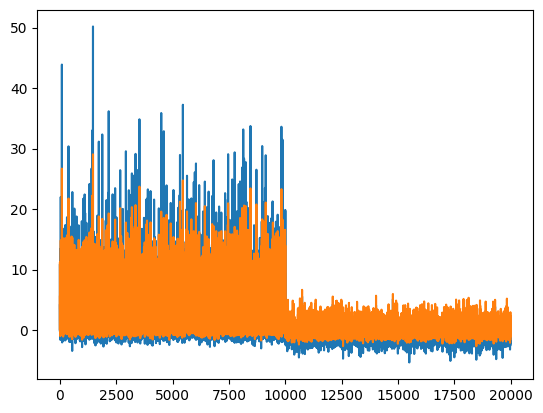

In [97]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

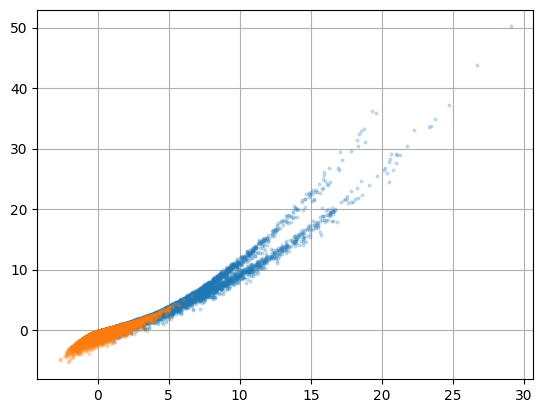

In [98]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

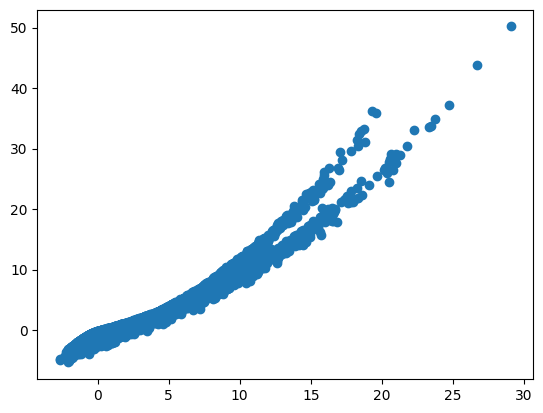

In [99]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [100]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [101]:
t_x_pred_new = model.predict(x_new)
t_x_pred_new = t_x_pred_new[:,0]

625/625 [==============================] - 1s 2ms/step


In [102]:
t_x_opt_new = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [103]:
DV_fun(y, t_x_pred), DV_fun(y, t_x_opt)

(1.9987443338050437, 2.297772030117542)

In [104]:
DV_fun(y_new, t_x_pred_new), DV_fun(y_new, t_x_opt_new)

(1.8261440686750199, 2.2293588048277138)

In [105]:
NWJ_fun(y, t_x_pred), NWJ_fun(y, t_x_opt)

(1.9969608551133422, 1.847678882458923)

In [106]:
NWJ_fun(y_new, t_x_pred_new), NWJ_fun(y_new, t_x_opt_new)

(1.802947891885601, 1.7963721641922066)